In [65]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plotting options
seaborn.set()
plt.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline


# Import training data

In [67]:
datadir = '/home/kristy/Documents/CountyExercisePredictions/'

data_train = pd.read_csv(datadir+'data_nonan_train.csv', index_col=0)
labels_train = pd.read_csv(datadir+'labels_train.csv', index_col=0, header=None)

# Normalize data
xScaler = StandardScaler()
yScaler = StandardScaler()
X_train = xScaler.fit_transform(data_train)
y_train = yScaler.fit_transform(labels_train)

print(X_train.shape)
print(y_train.shape)

(2552, 32)
(2552, 1)


# Reduce dimensionality 

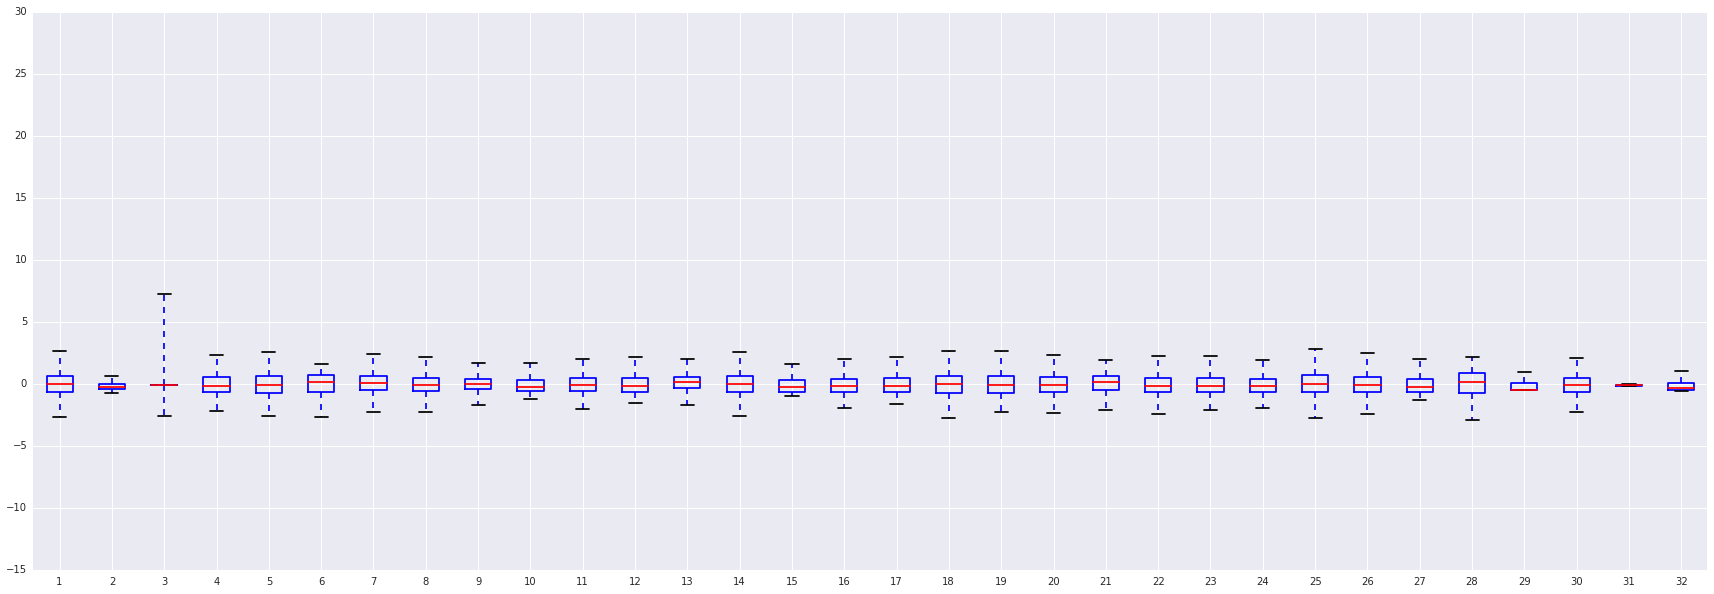

In [68]:
# Show all scaled values
plt.figure(figsize=[30,10])
plt.boxplot(X_train);

In [70]:
# Initialize PCA model that doesn't reduce dimensions at all in order to figure out how many components
# to put in final PCA model.
pca_full = PCA()

In [71]:
X_reduced = pca_full.fit_transform(X_train)

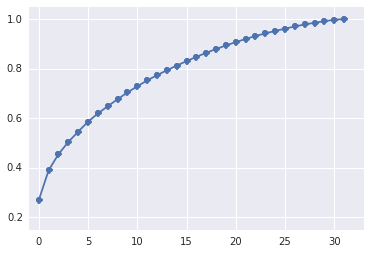

In [72]:
total_variance_explained = np.cumsum(np.sort(pca_full.explained_variance_ratio_)[::-1])
plt.plot(total_variance_explained, 'o-');
plt.ylim([0.15,1.05]);
plt.xlim([-1, len(total_variance_explained)+1]);

In [73]:
# Find the number of dimensions needed to explain 90% of variance
sum(total_variance_explained <= .9)

20

In [74]:
# Create a new PCA model that actually reduces the dimensions.
pca = PCA(n_components=21)
X_reduced = pca.fit_transform(X_train)
print sum(pca.explained_variance_ratio_)

0.906739508169


# Linear regression

### Other possible models:
* ridge regression
* CART
* regression decision trees
* neural network
* LASSO
* ridge regression
* random forest?
* regression with gradient boosting

In [75]:
# As a first attempt, try linear regression because it's easy.
from sklearn.linear_model import LinearRegression

In [76]:
lin_reg = LinearRegression()

In [77]:
lin_reg.fit(X_reduced, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
# Check performance on training set.
lin_reg.score(X_reduced, y_train)

0.7356000595813198

In [79]:
yhat_train = lin_reg.predict(X_reduced)

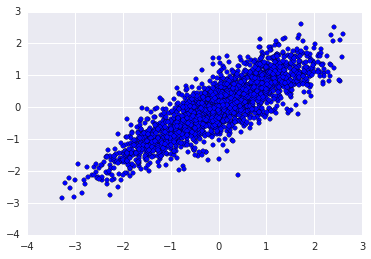

In [80]:
plt.scatter(y_train, yhat_train);

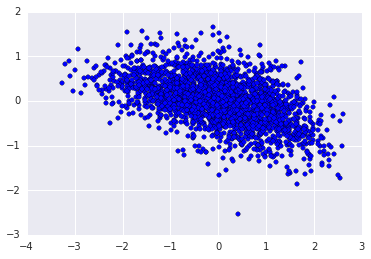

In [81]:
residuals = yhat_train - y_train
plt.scatter(y_train, residuals)

In [86]:
from sklearn import metrics

In [88]:
print(metrics.r2_score(y_train, yhat_train))
print(metrics.explained_variance_score(y_train, yhat_train))
print(metrics.mean_squared_error(y_train, yhat_train))

0.735600059581
0.735600059581
0.264399940419


## Look at individual covariates to see if any transformations jump out

In [53]:
X_reduced.shape

(2552, 21)

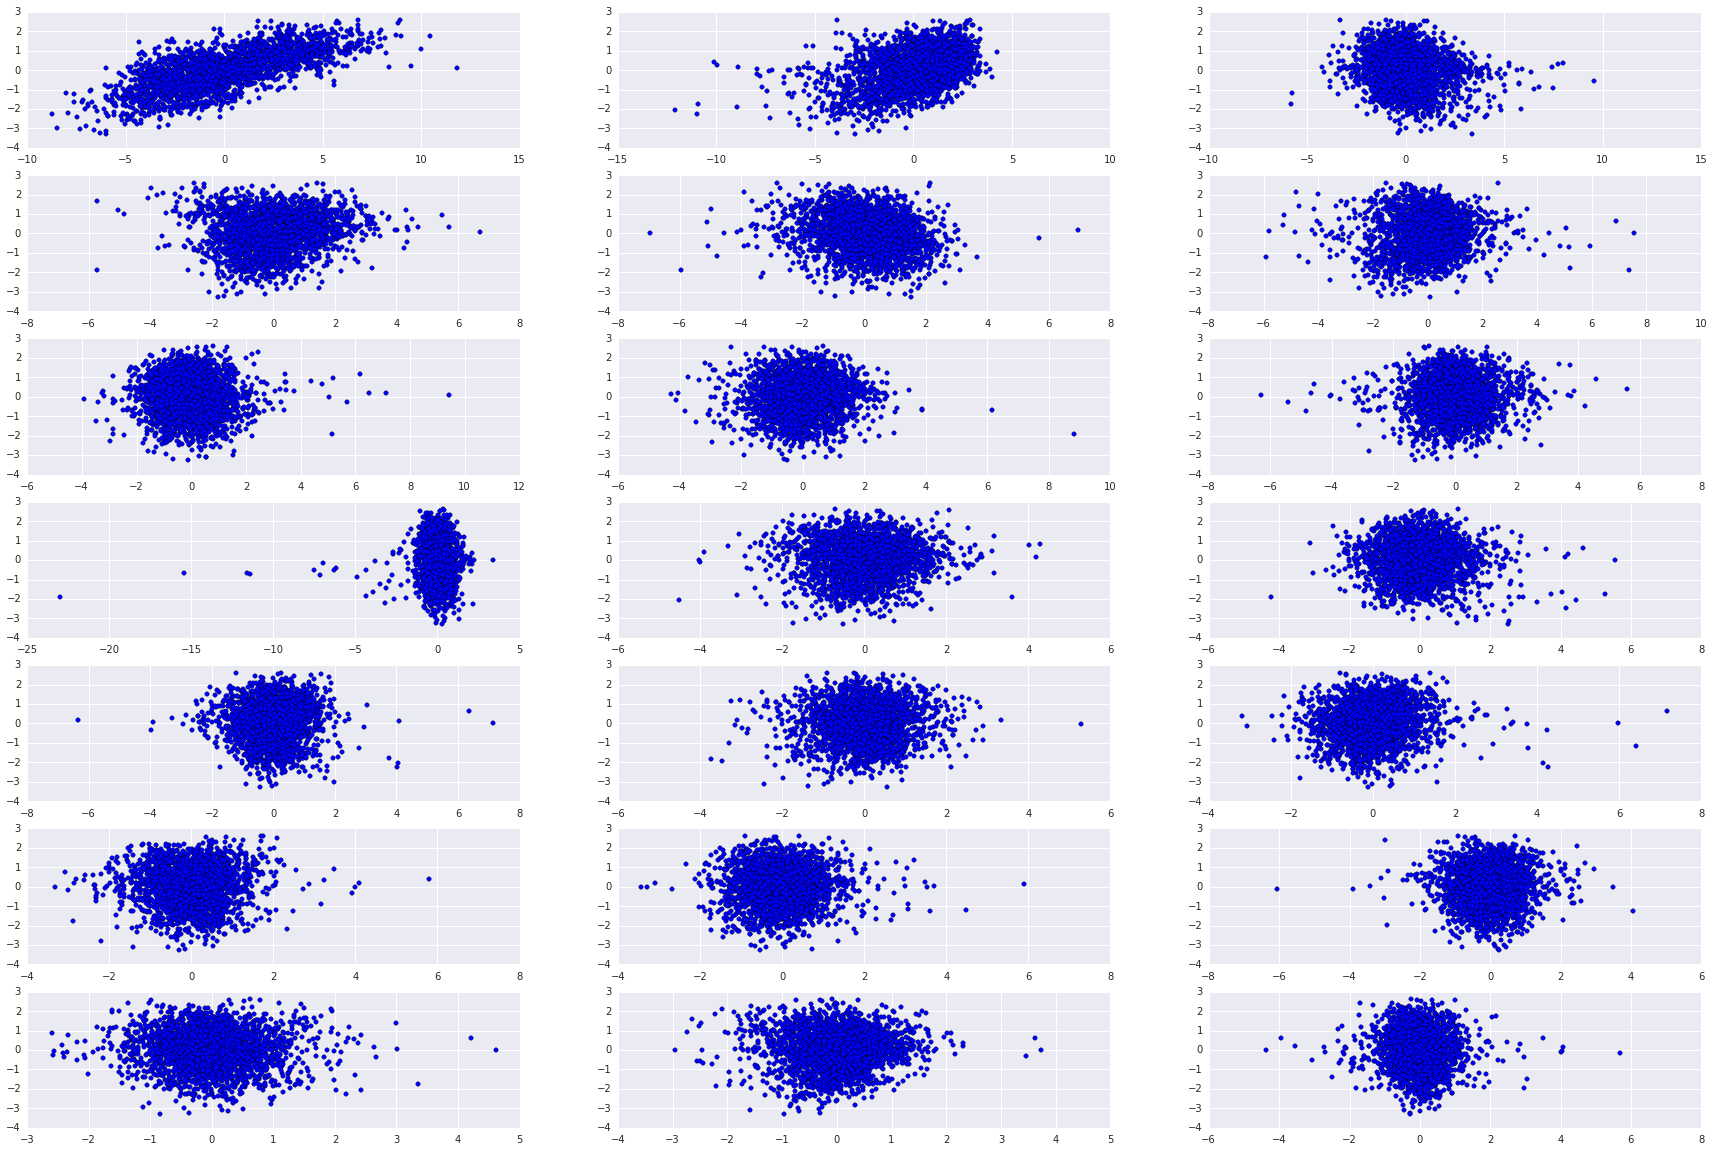

In [82]:
# PCA components
plt.figure(figsize=[30,20]);
for i in range(21):
    plt.subplot(7,3,i+1);
    plt.scatter(X_reduced[:,i], y_train);


In [56]:
X_train.shape

(2552, 32)

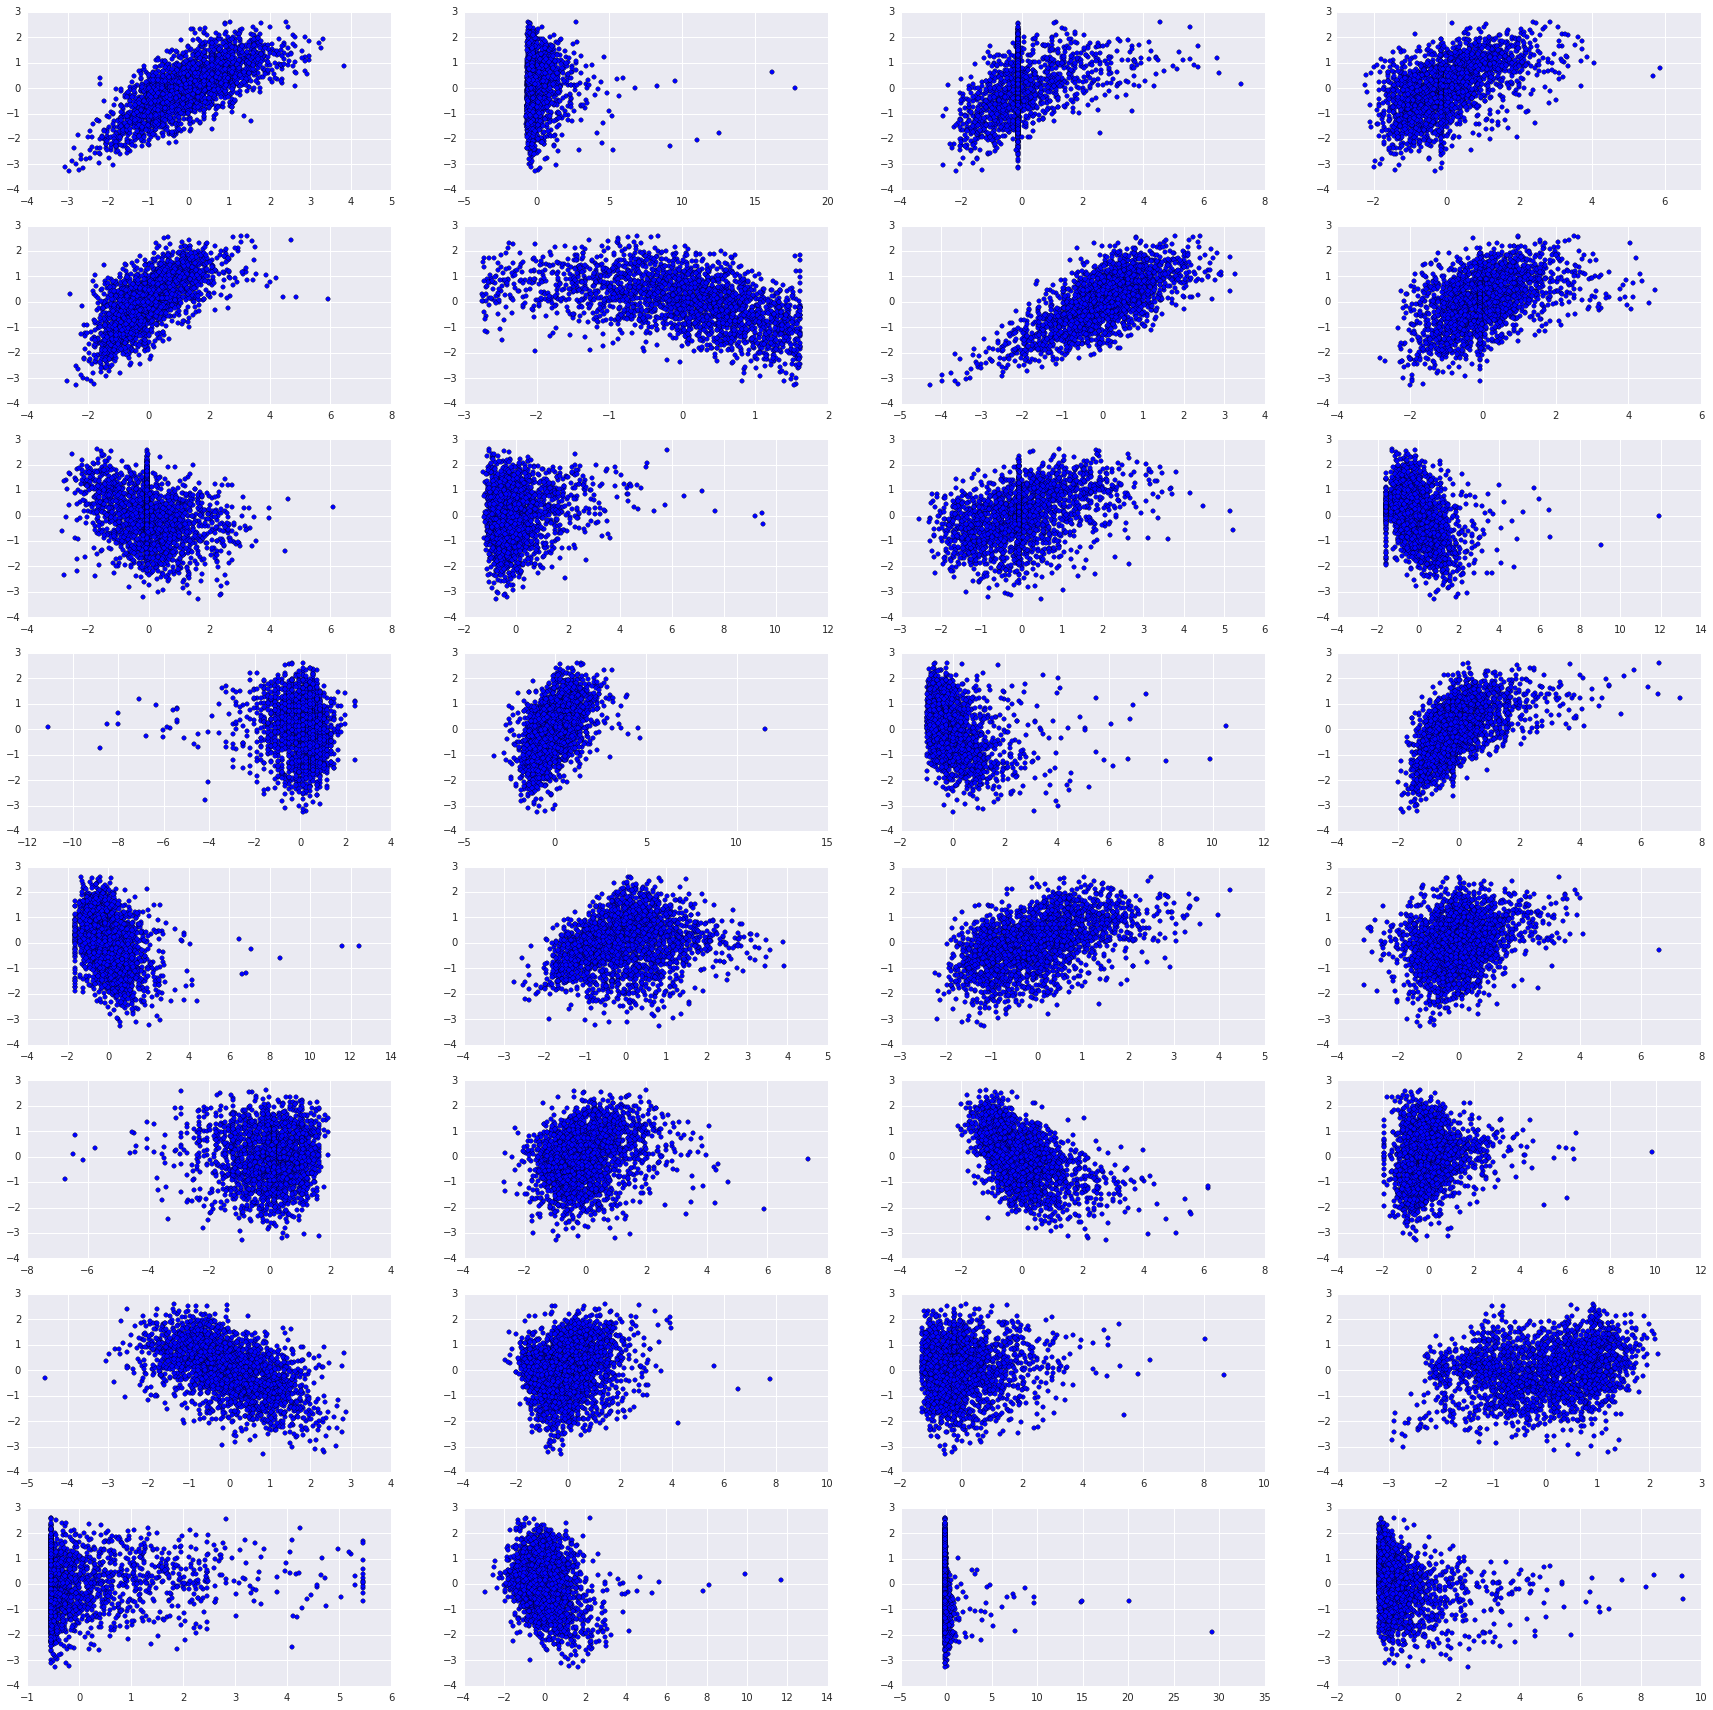

In [83]:
# Original covariates
plt.figure(figsize=[30,30]);
for i in range(32):
    plt.subplot(8,4,i+1);
    plt.scatter(X_train[:,i], y_train);

#### None of these look particularly nonlinear, so we won't worry about transforming the data here.

# Do linear regression on original covariates for comparison

In [85]:
full_lin_reg = LinearRegression()
full_lin_reg.fit(X_train, y_train)

# Check performance on training set.
print(full_lin_reg.score(X_train, y_train))

0.748469483139


#### This isn't a whole lot better than the initial model, so we'll stick with the reduced dataset

# Ridge regression

In [89]:
from sklearn.linear_model import Ridge

In [103]:
rdg_reg = Ridge()
rdg_reg.fit(X_reduced, y_train)
print("Ridge regression (training): {:0.4f}".format(rdg_reg.score(X_reduced, y_train)))

Ridge regression (training): 0.7356


#### It turns out ridge regression isn't an improvement. 

# Ridge regression with CV to find regularization param

In [111]:
from sklearn.linear_model import RidgeCV

In [117]:
rcv_reg = RidgeCV(alphas=[1, 10])
rcv_reg.fit(X_reduced, y_train)
print("Ridge regression with CV (training): {:0.4f}".format(rcv_reg.score(X_reduced, y_train)))

Ridge regression with CV (training): 0.7356


# Lasso

In [136]:
from sklearn.linear_model import Lasso, LassoCV

In [137]:
las_reg = Lasso()
las_reg.fit(X_reduced, y_train)
print("Lasso (training): {:0.4f}".format(las_reg.score(X_reduced, y_train)))

Lasso (training): 0.3679


#### This one is really bad  with the default alpha value. Let's do it again with a better value.

In [138]:
lcv_reg = LassoCV()
lcv_reg.fit(X_reduced, np.ravel(y_train))
print("Lasso CV (training): {:0.4f}".format(lcv_reg.score(X_reduced, y_train)))

Lasso CV (training): 0.7355


In [140]:
lcv_reg.alpha_

0.0023502615954269709

# Run models on test data

In [141]:
# import data
data_test = pd.read_csv(datadir+'data_nonan_test.csv', index_col=0)
labels_test = pd.read_csv(datadir+'labels_test.csv', index_col=0, header=None)

# Normalize data
X_test = xScaler.fit_transform(data_test)
y_test = yScaler.fit_transform(labels_test)

# Reduce dimensions
X_test_reduced = pca.transform(X_test)

# Run tests
print("Linear regression (testing): {:0.4f}".format(lin_reg.score(X_test_reduced, y_test)))
print("Ridge regression (testing): {:0.4f}".format(rdg_reg.score(X_test_reduced, y_test)))
print("Ridge regression with CV (testing): {:0.4f}".format(rcv_reg.score(X_test_reduced, y_test)))
print("Lasso (testing): {:0.4f}".format(las_reg.score(X_test_reduced, y_test)))
print("Lasso with CV (testing): {:0.4f}".format(lcv_reg.score(X_test_reduced, y_test)))


Linear regression (testing): 0.7373
Ridge regression (testing): 0.7373
Ridge regression with CV (testing): 0.7373
Lasso (testing): 0.3745
Lasso with CV (testing): 0.7373


# Conclusions
It doesn't really seem like the different regression methods perform differently on this dataset. They have decent performance that's slightly better on the test set than on the training set. That seems odd. It may indicate an overall problem with the model, but I'm not sure what.